##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Fashion MNIST with Keras and TPUs

## Overview

In this example, you can try out using tf.keras and Cloud TPUs to train a model on the fashion MNIST dataset. The model trains for 10 epochs on Cloud TPU and takes approximately 2 minutes to run.

This notebook is hosted on GitHub. To view it in its original repository, after opening the notebook, select **File > View on GitHub**.

## Learning objectives

In this Colab, you will learn how to:
*   Code for a standard conv-net that has 3 layers with drop-out and batch normalization between each layer in Keras.
*   Create and compile the model under a distribution strategy in order ot use TPUs.
*   Run a prediction to see how well the model can predict fashion categories and output the result.

## Instructions

<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

TPUs are located in Google Cloud, for optimal performance, they read data directly from Google Cloud Storage (GCS)

## Data, model, and training

Begin by downloading the fashion MNIST dataset using `tf.keras.datasets`, as shown below.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, InputLayer, Flatten, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import distutils
if distutils.version.LooseVersion(tf.__version__) <= '2.0':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')


In [3]:
!git clone https://github.com/altaga/Facemask-Dataset

fatal: destination path 'Facemask-Dataset' already exists and is not an empty directory.


In [4]:
print("The number of images with facemask labelled 'yes':",len(os.listdir('Facemask-Dataset/facemask-dataset/yes')))
print("The number of images without facemask labelled 'no':",len(os.listdir('Facemask-Dataset/facemask-dataset/no')))

The number of images with facemask labelled 'yes': 1916
The number of images without facemask labelled 'no': 1930


In [5]:
import cv2
import os

data = []
labels = []

mylist = os.listdir("Facemask-Dataset/facemask-dataset") # Set Dataset Folder

for x in mylist:
    mylist2 = os.listdir("Facemask-Dataset/facemask-dataset/"+str(x))
    label = str(x)
    for y in mylist2:
        # extract the class label from the folder name

        # load the input image (64x64) and preprocess it
        image = load_img("Facemask-Dataset/facemask-dataset/"+str(x)+"/"+str(y),color_mode="grayscale", target_size=(64, 64))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing

(x_train, x_test,y_train, y_test) = train_test_split(data, labels,
                                                        test_size=0.20, stratify=labels, random_state=42)

print('Training data: {}, {}'.format(x_train.shape, y_train.shape))
print('Test data: {}, {}'.format(x_test.shape, y_test.shape))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Training data: (3076, 64, 64, 1), (3076, 2)
Test data: (770, 64, 64, 1), (770, 2)


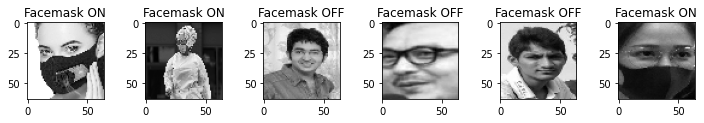

In [6]:
SampleSize=6
fig, axs = plt.subplots(1, SampleSize, figsize=(10, 10))
plt.tight_layout()

for i in range(SampleSize):
    axs[i].imshow(x_train[i].reshape(64, 64), 'gray')
    if(y_train[i][0]==0):
        tempLabel = "Facemask ON"
    else:
        tempLabel = "Facemask OFF"
    axs[i].set_title('{}'.format(tempLabel))

In [7]:
model = tf.keras.models.Sequential([
    InputLayer(input_shape=(64, 64, 1), name='input_data'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax', name='output_logits')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1)

In [9]:
history = model.fit(x_train,y_train,validation_data=(x_test, y_test),steps_per_epoch=1000,epochs=30, verbose=1 ,callbacks=[es])

Epoch 1/30
1000/1000 [==============================] - 61s 61ms/step - loss: 0.3446 - acc: 0.8382 - val_loss: 0.2310 - val_acc: 0.9000
Epoch 2/30
1000/1000 [==============================] - 61s 61ms/step - loss: 0.1594 - acc: 0.9383 - val_loss: 0.1647 - val_acc: 0.9325
Epoch 3/30
1000/1000 [==============================] - 61s 61ms/step - loss: 0.0865 - acc: 0.9680 - val_loss: 0.1664 - val_acc: 0.9403
Epoch 00003: early stopping


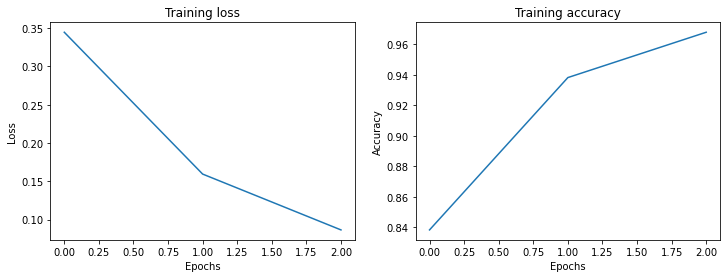

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['loss'])
axs[0].set_title('Training loss')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(history.history['acc'])
axs[1].set_title('Training accuracy')
axs[1].set(xlabel='Epochs', ylabel='Accuracy')
plt.show()

In [11]:
loss, accuracy = model.evaluate(x_test,y_test)
print("Test loss: {}".format(loss))
print("Test accuracy: {}".format(accuracy))

25/25 [==============================] - 2s 90ms/step - loss: 0.1664 - acc: 0.9403
Test loss: 0.16640129685401917
Test accuracy: 0.9402597546577454


In [12]:
!ls

converted_model.tflite	Facemask-Dataset       fashion_mnist.h5
download		facemask-detection.h5  sample_data


In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_quantized_model)

6724300